In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import re
import os
import random
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())
print(os.getcwd())

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
import catboost
from catboost import CatBoostRegressor
print(f'CatBoost Version : {catboost.__version__}')

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

True 1
/data/ephemeral/Project
CatBoost Version : 1.2.2


![data](./code/data/Data_Schema.png)

In [2]:
books = pd.read_csv('./code/data/books.csv')
users = pd.read_csv('./code/data/users.csv')
rating_train = pd.read_csv('./code/data/train_ratings.csv')
rating_test = pd.read_csv('./code/data/test_ratings.csv')
print(books.shape, users.shape, rating_train.shape, rating_test.shape)

(149570, 10) (68092, 3) (306795, 3) (76699, 3)


## `books`

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


- `isbn`
    - https://sciencing.com/difference-isbn-13-isbn-10-5890031.html
    - group identifier / publisher identifier / title identifier / and check digit로 구성
    - Format : X-XXX-XXXXX-X

> **ISBN 확인**
- URL 정보를 사용해서 ISBN이 재대로 입력됐는지 확인

In [4]:
books['img_url_isbn'] = books['img_url'].apply(lambda x : x.split('/')[5].split('.')[0])
books[books['isbn'] != books['img_url_isbn']]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,img_url_isbn


In [5]:
books.drop(columns = 'img_url_isbn', inplace = True)

- `book_author` 결측치 확인
    - 실제 저자가 없는 책
    - 동일한 `book_title`의 데이터도 없음
    - => 동일한 `publisher`의 최빈값으로 대체

In [6]:
books[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg


In [7]:
books.loc[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0], 'book_author'] = \
    books.loc[books['publisher'] == books.loc[books['book_author'].isna(), 'publisher'].values[0], 'book_author'].mode().values[0]
print(books['book_author'].isna().sum())

0


- `year_of_publication`
    - 10년 단위로 범주화

In [8]:
def preprocess_year(x) :
    if x < 1970 :
        return 1970
    elif (x >= 1970) and (x < 1980) :
        return 1980
    elif (x >= 1980) and (x < 1990) :
        return 1990
    elif (x >= 1990) and (x < 2000) :
        return 2000
    else :
        return 2010
    
books['years'] = books['year_of_publication'].apply(preprocess_year)
books['years'].value_counts()

years
2000    72358
2010    46301
1990    23809
1980     5636
1970     1466
Name: count, dtype: int64

- `publisher`
    - `isbn`의 앞 4개의 숫자를 활용하여 `new_publisher` 생성

In [9]:
publisher_dict = (books['publisher'].value_counts()).to_dict()
publisher_count_df = pd.DataFrame(list(publisher_dict.items()), columns = ['publisher', 'count'])

publisher_count_df = publisher_count_df.sort_values(by = ['count'], ascending = False)
display(publisher_count_df.head(), books['publisher'].nunique())

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


11571

In [10]:
modify_list = publisher_count_df[publisher_count_df['count'] > 1]['publisher'].values

for publisher in tqdm.tqdm(modify_list) :
    try :
        number = books[books['publisher'] == publisher]['isbn'].apply(lambda x : x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x : x[:4]) == number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x : x[:4]) == number].index, 'new_publisher'] = right_publisher
    except :
        pass
    
print(books['new_publisher'].nunique())

100%|██████████| 5276/5276 [07:42<00:00, 11.41it/s]

875


In [42]:
new_publisher = books['new_publisher']

In [51]:
books['new_publisher'].value_counts()

new_publisher
Pocket                  7306
Harlequin               5268
Bantam Books            4816
St. Martin's Press      4043
Vintage Books USA       3822
                        ... 
Cornelsen Lernhilfen       1
Ecco (HarperCollins)       1
Verlag am Goetheanum       1
Janus                      1
Iceland Review             1
Name: count, Length: 1767, dtype: int64

- `language`, `category`, `summary`
    - `language` & `category` & `summary`가 모두 결측인 행 -> 67227행
    - `language` & `summary`만 결측인 행 -> 67227 + 1624행

In [11]:
display(books.loc[books['language'].isna(), ['language', 'category', 'summary']])
display(books.loc[books['language'].isna() & books['category'].notnull()])
display(books.loc[books['language'].isna() & books['summary'].notnull()])

,language,category,summary
5,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN
10,NaN,NaN,NaN
11,NaN,NaN,NaN
...,...,...,...
149560,NaN,NaN,NaN
149561,NaN,NaN,NaN
149564,NaN,NaN,NaN
149567,NaN,NaN,NaN


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,years,new_publisher


- `language`는 `isbn`의 region 정보를 활용하여 결측치 대체

In [12]:
region_code = set([code[:1] for code in books['isbn']])

region_lang = dict()

for code in region_code :
    lang = books.loc[books['isbn'].str.startswith(str(code)), 'language']
    mode = lang.mode()[0] if not code == 'B' else 'en' # 'B'로 시작하는 행들은 모두 NaN여서, 'en'으로 대체
    books.loc[(books['isbn'].str.startswith(str(code))) & (books['language'].isna()), 'language'] = mode

books['language'].isna().sum()

0

- `category`
    - 상위 카테고리인 `category_high`를 생성

In [13]:
# 대괄호 삭제
books['category'] = books['category'].apply(lambda x : re.sub('[\W_]+',  ' ', str(x).lower()).strip())

category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,nan,68851
1,fiction,33016
2,juvenile fiction,5835
3,biography autobiography,3326
4,history,1927


In [14]:
books['category_high'] = books['category'].copy()

categories = ['garden', 'crafts', 'physics', 'adventure', 'music', 'fiction', 'nonfiction', 'science', 'science fiction', 'social', 'homicide', 
              'sociology', 'disease', 'religion', 'christian', 'philosophy', 'psycholog', 'mathemat', 'agricult', 'environmental',
              'business', 'poetry', 'drama', 'literary', 'travel', 'motion picture', 'children', 'cook', 'literature', 'electronic', 
              'humor', 'animal', 'bird', 'photograph', 'computer', 'house', 'ecology', 'family', 'architect', 'camp', 'criminal', 'language', 'india']

for category in categories :
    books.loc[books[books['category'].str.contains(category, na = False)].index, 'category_high'] = category

In [15]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category', 'count']
category_high_df.head(10)

,category,count
0,nan,68851
1,fiction,39678
2,biography autobiography,3326
3,history,1927
4,religion,1824
5,nonfiction,1427
6,humor,1291
7,social,1271
8,business,1146
9,cook,1125


In [16]:
# 5개 이하인 항목은 others
others_list = category_high_df[category_high_df['count'] < 5]['category'].values
print(len(others_list))

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high'] = 'others'

2856


In [17]:
books['category_high'] = books['category_high'].replace('nan', np.nan)
books['category_high'] = books['category_high'].replace('unknown', np.nan)
print(books['category_high'].isna().sum())

books['category_high'].fillna('fiction', inplace = True)

68851


In [52]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB


In [53]:
books.to_csv('./code/data/books_preprocessed.csv', index = False)

## `users`

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


- `location`

In [21]:
users['location'] = users['location'].str.replace(r'[^a-zA-Z:,]', '', regex = True)

users['city'] = users['location'].apply(lambda x : x.split(',')[0].strip())
users['state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

users[['location', 'city', 'state', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  68092 non-null  object
 1   city      67963 non-null  object
 2   state     64838 non-null  object
 3   country   65968 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


- `city`가 가장 결측치가 적지만, 고윳값이 많아서 모델링할 때 그닥 좋은 성능을 낼 것 같지 않아보임
    - `country`의 결측치를 채워서 분석에 사용하는 쪽으로 방향을 설정

In [22]:
print(users['city'].nunique(), users['state'].nunique(), users['country'].nunique())

11958 1499 316


In [23]:
# country가 결측 / state 결측 X인 경우
states = users[(users['state'].notnull()) & (users['country'].isna())]['state'].values

for state in tqdm.tqdm(states) :
    try :
        country = users.loc[(users['location'].str.contains(state)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(state)) & (users['country'].isna()), 'country'] = country
    except :
        pass

# country가 결측 / city 결측 X인 경우
cities = users[(users['city'].notnull()) & (users['country'].isna())]['city'].values

for city in tqdm.tqdm(cities) :
    try :
        country = users.loc[(users['location'].str.contains(city)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(city)) & (users['country'].isna()), 'country'] = country
    except :
        pass

# 각 나라 별로 location의 최빈값으로 대체
countries_list = users['country'].value_counts()
for country in tqdm.tqdm(countries_list.index) :
    try :
        new_country = users.loc[(users['location'].str.contains(country)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(country)) & (users['country'] == country), 
                  'country'] = new_country
    except :
        pass

  0%|          | 0/623 [00:00<?, ?it/s]

100%|██████████| 316/316 [00:16<00:00, 18.74it/s]


In [24]:
print(users['country'].unique())

['canada' nan 'usa' 'malaysia' 'newzealand' 'finland' 'unitedkingdom'
 'portugal' 'brazil' 'germany' 'austria' 'italy' 'australia' 'france'
 'costarica' 'netherlands' 'poland' 'iran' 'aruba' 'spain' 'taiwan'
 'singapore' 'argentina' 'romania' 'greece' 'ireland' 'belgium'
 'philippines' 'southafrica' 'switzerland' 'yugoslavia' 'turkey' 'japan'
 'china' 'qatar' 'sweden' 'kuwait' 'indonesia' 'nepal' 'unitedstates'
 'slovakia' 'norway' 'dominicanrepublic' 'southkorea' 'macedonia' 'kenya'
 'mauritius' 'madagascar' 'israel' 'egypt' 'denmark' 'guatemala'
 'euskalherria' 'palau' 'czechrepublic' 'venezuela' 'faraway' 'antarctica'
 'andorra' 'bulgaria' 'nigeria' 'everywhereandanywhere' 'slovenia' 'chile'
 'kcb' 'hongkong' 'luxembourg' 'iceland' 'honduras' 'zambia' 'zimbabwe'
 'phillipines' 'trinidadandtobago' 'belize' 'algeria' 'vanwert' 'bermuda'
 'bahamas' 'saudiarabia' 'cyprus' 'universe' 'albania' 'mozambique'
 'ukraine' 'pakistan' 'guinea' 'caymanislands' 'tdzimi' 'tonga' 'srilanka'
 'saint

- `country`의 오타나 오기입되어 있는 값 처리
- canada -> 'canada', 'cananda', 'vvh', 'lkjlj'
- italy -> 'italia', 'italy', 'litalia', 'ineurope'
- phillipines -> 'phillipines', 'phillippines'
- spain -> 'catalunyaspain', 'spain'
- unitedkingdom -> 'unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'
- usa -> 'unitedstates', 'unitedstaes', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'
- uruguay -> 'urugua', 'uruguay'

In [25]:
print(f'Before : {users["country"].nunique()}')
country_mapping = {
    'canada': ['canada', 'cananda', 'vvh', 'lkjlj'],
    'italy': ['italia', 'italy', 'litalia', 'ineurope'],
    'phillipines': ['phillipines', 'phillippines'],
    'spain': ['catalunyaspain', 'spain'],
    'unitedkingdom': ['unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'],
    'usa': ['unitedstates', 'unitedstaes', 'unitedsates', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'],
    'uruguay': ['urugua', 'uruguay']
}

for target_country, aliases in country_mapping.items() :
    users['country'].replace(aliases, target_country, inplace = True)

print(f'After : {users["country"].nunique()}')

Before : 184
After : 166


In [26]:
print(users['country'].isna().sum())
users['country'].value_counts().to_frame()

94


,count
country,
usa,45756
canada,6490
germany,3591
unitedkingdom,3026
australia,1834
...,...
labelgique,1
lafrance,1
gabon,1


In [27]:
# 10개 이하의 country를 others로 변환
others = users['country'].value_counts()[users['country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['country'] == country), 'country'] = 'others'
    except :
        pass

100%|██████████| 118/118 [00:00<00:00, 226.39it/s]


In [28]:
# 나머지 결측치에 대해서도 others로 변환
users['country'] = users['country'].fillna('others')
print(users['country'].nunique())

49


- `age`
    - 국가별 `age`의 중앙값으로 대체
    - 국가별 `age`의 중앙값이 존재하지 않는 경우, 전체 `age`의 중앙값으로 대체

In [29]:
country_age_median = users.groupby('country')['age'].median()
users['age'] = users.apply(lambda x : country_age_median[x['country']] if pd.isna(x['age']) else x['age'], axis = 1)

global_age_median = users['age'].median()
users['age'].fillna(global_age_median, inplace = True)
print(users['age'].isna().sum())

0


- 10살 단위 연령대로 분할하여 `new_age` 변수 생성

In [30]:
users['new_age'] = ((users['age'] // 10) * 10).astype(int)
users[['age', 'new_age']]

,age,new_age
0,33.0,30
1,49.0,40
2,31.0,30
3,30.0,30
4,36.0,30
...,...,...
68087,54.0,50
68088,74.0,70
68089,36.0,30
68090,33.0,30


In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       68092 non-null  float64
 3   city      67963 non-null  object 
 4   state     64838 non-null  object 
 5   country   68092 non-null  object 
 6   new_age   68092 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 3.6+ MB


In [32]:
users.to_csv('./code/data/users_preprocessed.csv', index = False)

## `ratings`와 Merge

In [138]:
path = './code/data/'
books_pre = pd.read_csv(path + 'books_preprocessed.csv')
users_pre = pd.read_csv(path + 'users_preprocessed.csv')
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books_pre.shape, users_pre.shape, train_ratings.shape, test_ratings.shape)

(149570, 13) (68092, 7) (306795, 3) (76699, 3)


In [141]:
display(books_pre.info(), users_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  years                149570 non-null  int64  
 11  new_publisher        149570 non-null  object 
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entr

None

None

In [142]:
books_final = books_pre[['isbn', 'language', 'years', 'new_publisher', 'category_high']]
users_final = users_pre[['user_id', 'country', 'new_age']]

In [143]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, train_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
train_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  int64  
 1   country        306795 non-null  object 
 2   new_age        306795 non-null  int64  
 3   isbn           306795 non-null  object 
 4   language       306795 non-null  object 
 5   years          306795 non-null  float64
 6   new_publisher  306795 non-null  object 
 7   category_high  306795 non-null  object 
 8   rating         306795 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 21.1+ MB


In [144]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        76699 non-null  int64  
 1   country        76699 non-null  object 
 2   new_age        76699 non-null  int64  
 3   isbn           76699 non-null  object 
 4   language       76699 non-null  object 
 5   years          76699 non-null  float64
 6   new_publisher  76699 non-null  object 
 7   category_high  76699 non-null  object 
 8   rating         76699 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 5.3+ MB


- `avg_rating`
    - `user_id`별 평균 `rating`의 값을 계산

In [145]:
avg_rating = train_df.groupby('user_id', as_index = False)['rating'].mean().rename({'rating' : 'avg_rating'}, axis = 1)
train_df = pd.merge(train_df, avg_rating, how = 'left', on = 'user_id')
test_df = pd.merge(test_df, avg_rating, how = 'left', on = 'user_id')
test_df['avg_rating'].fillna(train_df['rating'].mean(), inplace = True)

In [146]:
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['new_age'] = train_df['new_age'].astype('category')
train_df['years'] = train_df['years'].astype('int').astype('category')
train_df['rating'] = train_df['rating'].astype('int')

test_df['user_id'] = test_df['user_id'].astype('str')
test_df['new_age'] = test_df['new_age'].astype('category')
test_df['years'] = test_df['years'].astype('int').astype('category')
test_df['rating'] = test_df['rating'].astype('int')

In [147]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   user_id        306795 non-null  object  
 1   country        306795 non-null  object  
 2   new_age        306795 non-null  category
 3   isbn           306795 non-null  object  
 4   language       306795 non-null  object  
 5   years          306795 non-null  category
 6   new_publisher  306795 non-null  object  
 7   category_high  306795 non-null  object  
 8   rating         306795 non-null  int64   
 9   avg_rating     306795 non-null  float64 
dtypes: category(2), float64(1), int64(1), object(6)
memory usage: 19.3+ MB


In [148]:
train_df.head()

,user_id,country,new_age,isbn,language,years,new_publisher,category_high,rating,avg_rating
0,8,canada,30,0002005018,en,2010,Collins,actresses,4,4.428571
1,67544,canada,30,0002005018,en,2010,Collins,actresses,7,7.285714
2,123629,canada,30,0002005018,en,2010,Collins,actresses,8,8.000000
3,200273,canada,30,0002005018,en,2010,Collins,actresses,8,8.000000
4,210926,canada,30,0002005018,en,2010,Collins,actresses,9,8.400000


# Model


In [149]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(columns = 'rating'), train_df['rating'],
                                                      test_size = 0.2, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(245436, 9) (245436,) (61359, 9) (61359,)


## Catboost

In [169]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    model = CatBoostRegressor(**param, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [0, 1, 2, 3, 4, 5, 6, 7])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 30)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

In [155]:
best_params = {'learning_rate': 0.1, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

In [158]:
X_data, y_data = train_df.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
valid_rmse = []

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = best_params # study.best_params
    
    cat_reg = CatBoostRegressor(**param, loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [0, 1, 2, 3, 4, 5, 6, 7])
    cat_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                verbose = 300, early_stopping_rounds = 100)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score}')


print(f'모델 RMSE 평균 : {np.array(valid_rmse).mean()} \n')

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 2.3601447	test: 2.3601447	test1: 2.3595741	best: 2.3595741 (0)	total: 54.3ms	remaining: 54.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.790011507
bestIteration = 328

Shrink model to first 329 iterations.


 20%|██        | 1/5 [02:02<08:10, 122.64s/it]

Valid Set 1 번째 Fold RMSE : 1.790011507124709
0:	learn: 2.3603428	test: 2.3603428	test1: 2.3597548	best: 2.3597548 (0)	total: 62.7ms	remaining: 1m 2s
500:	learn: 1.7549394	test: 1.6340445	test1: 1.7894085	best: 1.7893725 (471)	total: 2m 23s	remaining: 2m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.789327417
bestIteration = 518

Shrink model to first 519 iterations.


 40%|████      | 2/5 [05:02<07:48, 156.10s/it]

Valid Set 2 번째 Fold RMSE : 1.7893274168508637
0:	learn: 2.3598536	test: 2.3598536	test1: 2.3603772	best: 2.3603772 (0)	total: 51.3ms	remaining: 51.3s
500:	learn: 1.7569973	test: 1.6419583	test1: 1.7988500	best: 1.7987573 (475)	total: 2m 22s	remaining: 2m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.798446584
bestIteration = 598

Shrink model to first 599 iterations.


 60%|██████    | 3/5 [08:22<05:52, 176.43s/it]

Valid Set 3 번째 Fold RMSE : 1.7984465838729526
0:	learn: 2.3597441	test: 2.3597441	test1: 2.3604490	best: 2.3604490 (0)	total: 50.6ms	remaining: 50.5s
500:	learn: 1.7473209	test: 1.6387241	test1: 1.7984622	best: 1.7984465 (454)	total: 2m 20s	remaining: 2m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.798077996
bestIteration = 572

Shrink model to first 573 iterations.


 80%|████████  | 4/5 [11:34<03:02, 182.50s/it]

Valid Set 4 번째 Fold RMSE : 1.7980779962418476
0:	learn: 2.3604448	test: 2.3604448	test1: 2.3602247	best: 2.3602247 (0)	total: 49.2ms	remaining: 49.1s
500:	learn: 1.7548798	test: 1.6268184	test1: 1.7945361	best: 1.7944074 (416)	total: 2m 22s	remaining: 2m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.794407436
bestIteration = 416

Shrink model to first 417 iterations.


100%|██████████| 5/5 [14:03<00:00, 168.74s/it]

Valid Set 5 번째 Fold RMSE : 1.79440743635232
모델 RMSE 평균 : 1.7940541880885383


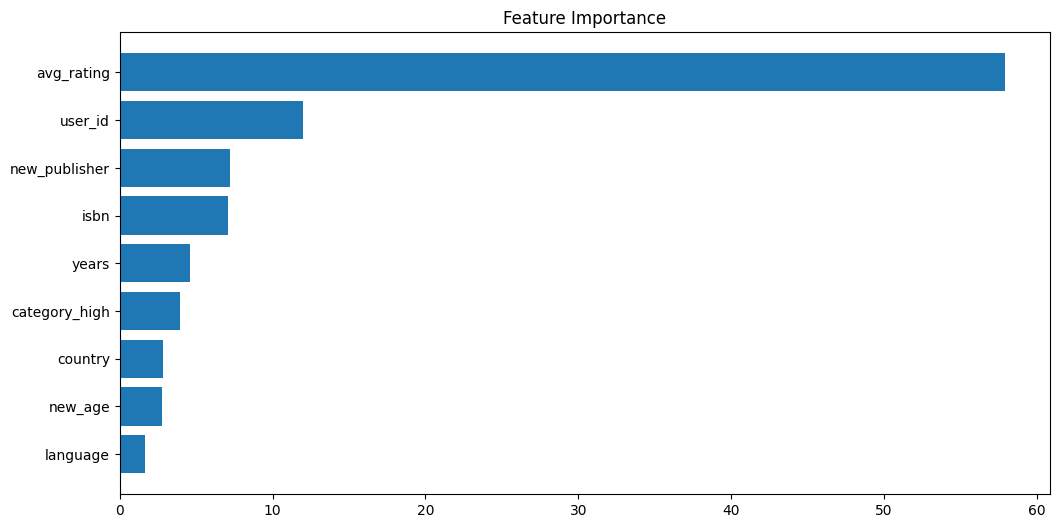

In [160]:
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [161]:
test_pred = cat_reg.predict(test_df.drop(columns = 'rating'))
test_pred

array([6.69311146, 7.60695351, 8.35798571, ..., 6.65210741, 3.13041396,
       6.26810088])

In [166]:
test_df['rating'] = test_pred.round().astype('int')
submit = test_df[['user_id', 'isbn', 'rating']]
submit.to_csv('./code/submit/Catboost_Optuna.csv', index = False)